### Load raw dataset

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

yolosac = pd.read_csv('data/yolosac.csv')
yolosac['category'] = yolosac['category'].apply(eval)
print (yolosac['category'])

0                                      [Massage therapist]
1                                      [Massage therapist]
2                                          [Door supplier]
3                                                 [Church]
4                                                 [Church]
                               ...                        
17933                                [American restaurant]
17934                                        [Gas station]
17935                                      [Movie theater]
17936                                   [Pizza restaurant]
17937    [Electronics store, Appliance store, Computer ...
Name: category, Length: 17938, dtype: object


In [2]:
# Top 30 business categories
print(yolosac['category'].explode().value_counts().iloc[:30])
yolosac['category'].explode().value_counts().to_csv('data/business_categories.csv')

category
Restaurant              1352
Fast food restaurant     649
Auto repair shop         513
Park                     463
Mexican restaurant       429
Beauty salon             428
Takeout Restaurant       398
Coffee shop              394
Grocery store            382
Breakfast restaurant     380
Gas station              377
Hair salon               364
Sandwich shop            359
Cafe                     353
American restaurant      347
Tourist attraction       322
Pizza restaurant         320
Caterer                  319
Nail salon               318
Convenience store        310
Bar                      285
Hamburger restaurant     285
Clothing store           260
Cell phone store         235
Tire shop                222
Barber shop              211
ATM                      210
Used car dealer          209
Chinese restaurant       207
Auto parts store         199
Name: count, dtype: int64


### Find correlation between raw categories

#### One Hot Encoding of raw categories

In [3]:
# Credit: https://towardsdatascience.com/dealing-with-list-values-in-pandas-dataframes-a177e534f173
def bool_df(item_lists, unique_items):
  bool_dict = {}
  # Iterate over all tags
  for i, item in enumerate(unique_items):
    # Apply Boolean mask
    bool_dict[item] = item_lists.apply(lambda x: item in x)
  
  # Return as dataframe
  return pd.DataFrame(bool_dict)

In [4]:
# List of unique business categories with frequency
unique_cats = yolosac['category'].explode().value_counts()
# Generate boolean matrix where each category is a column (one hot encoding)
categories_bool = bool_df(item_lists=yolosac['category'], unique_items=unique_cats.index)
categories_bool

,Restaurant,Fast food restaurant,Auto repair shop,Park,Mexican restaurant,Beauty salon,Takeout Restaurant,Coffee shop,Grocery store,Breakfast restaurant,...,Amusement ride supplier,Fund management company,Raw food restaurant,Civil engineering company,Industrial building,Mechanical contractor,Finance broker,Stock broker,Asphalt contractor,Wildlife park
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17933,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17935,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
17936,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


#### Correlation Matrix between raw buiness categories

In [5]:
# Generate correlation table between categories (takes ~2 mins)
categories_corr = categories_bool.corr(method="pearson")
categories_corr

,Restaurant,Fast food restaurant,Auto repair shop,Park,Mexican restaurant,Beauty salon,Takeout Restaurant,Coffee shop,Grocery store,Breakfast restaurant,...,Amusement ride supplier,Fund management company,Raw food restaurant,Civil engineering company,Industrial building,Mechanical contractor,Finance broker,Stock broker,Asphalt contractor,Wildlife park
Restaurant,1.000000,0.345007,-0.048988,-0.046473,0.128078,-0.043253,0.296780,0.065274,-0.034801,0.180908,...,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132,-0.002132
Fast food restaurant,0.345007,1.000000,-0.033244,-0.031537,0.186558,-0.028335,0.424817,0.101322,-0.028580,0.294913,...,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447,-0.001447
Auto repair shop,-0.048988,-0.033244,1.000000,-0.027929,-0.026858,-0.026826,-0.025846,-0.025713,-0.025310,-0.025242,...,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281,-0.001281
Park,-0.046473,-0.031537,-0.027929,1.000000,-0.025479,-0.025448,-0.024519,-0.024393,-0.024010,-0.023946,...,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,-0.001215,0.045872
Mexican restaurant,0.128078,0.186558,-0.026858,-0.025479,1.000000,-0.024472,0.130006,-0.023458,-0.010453,0.118869,...,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169,-0.001169
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Mechanical contractor,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001125,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,1.000000,-0.000056,-0.000056,-0.000056,-0.000056
Finance broker,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001125,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,1.000000,-0.000056,-0.000056
Stock broker,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001125,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,1.000000,-0.000056,-0.000056
Asphalt contractor,-0.002132,-0.001447,-0.001281,-0.001215,-0.001169,-0.001167,-0.001125,-0.001119,-0.001101,-0.001098,...,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,-0.000056,1.000000,-0.000056


In [6]:
# Helper function to extract similar categories
def similarCats(cat):
  return categories_corr[str(cat)].sort_values(ascending=False).loc[categories_corr[str(cat)] > 0].index.to_list()

### Extract simplified business categories

In [ ]:
red_cat_names = [('restaurant', ['Restaurant']), ('recreation', ['Park']), ()]
reduced_categories = {'Restaurant'}

In [7]:
restaurant = similarCats('Restaurant')
print(*restaurant, sep='\n')

Restaurant
Fast food restaurant
Sandwich shop
Takeout Restaurant
Caterer
Hamburger restaurant
Lunch restaurant
American restaurant
Breakfast restaurant
Tex-Mex restaurant
Bar
Burrito restaurant
Taco restaurant
Asian restaurant
Vegetarian restaurant
Mexican restaurant
Chinese restaurant
Salad shop
Diner
Steak house
Family restaurant
Seafood restaurant
Bar & grill
Hot dog restaurant
Californian restaurant
Japanese restaurant
Gastropub
Brunch restaurant
Deli
Cajun restaurant
Sports bar
Juice shop
European restaurant
Pasta shop
Box lunch supplier
Barbecue restaurant
Coffee shop
Sushi restaurant
Fine dining restaurant
Chicken wings restaurant
Hot dog stand
Down home cooking restaurant
Italian restaurant
Cafeteria
Traditional American restaurant
Soup restaurant
New American restaurant
Delivery Restaurant
Thai restaurant
Vietnamese restaurant
Takeout restaurant
Buffet restaurant
Mediterranean restaurant
Grill
Pizza restaurant
Bistro
Greek restaurant
Catering food and drink supplier
Pretzel st

In [28]:

for i in restaurant:
  print(i, categories_bool[i].value_counts()[True])

Restaurant 1352
Fast food restaurant 649
Sandwich shop 359
Takeout Restaurant 398
Caterer 319
Hamburger restaurant 285
Lunch restaurant 86
American restaurant 347
Breakfast restaurant 380
Tex-Mex restaurant 61
Bar 285
Burrito restaurant 65
Taco restaurant 81
Asian restaurant 150
Vegetarian restaurant 124
Mexican restaurant 429
Chinese restaurant 207
Salad shop 58
Diner 70
Steak house 43
Family restaurant 147
Seafood restaurant 114
Bar & grill 93
Hot dog restaurant 27
Californian restaurant 18
Japanese restaurant 111
Gastropub 15
Brunch restaurant 38
Deli 121
Cajun restaurant 19
Sports bar 54
Juice shop 66
European restaurant 11
Pasta shop 7
Box lunch supplier 9
Barbecue restaurant 46
Coffee shop 394
Sushi restaurant 92
Fine dining restaurant 19
Chicken wings restaurant 100
Hot dog stand 7
Down home cooking restaurant 7
Italian restaurant 153
Cafeteria 8
Traditional American restaurant 8
Soup restaurant 28
New American restaurant 21
Delivery Restaurant 100
Thai restaurant 78
Vietnamese 

In [8]:
hotel = similarCats('Hotel')
print(*hotel, sep='\n')

Hotel
Indoor lodging
Lodge
Extended stay hotel
Meeting planning service
Motel
Inn
Bed & breakfast
Wedding venue
Army facility
Gambling house
Function room facility
Event venue
Meeting room
Lodging
Casino
Banquet hall
Conference center
Business center
Boutique
Bar


In [9]:
yolosac[categories_bool['Hotel'] & categories_bool['Restaurant']]

,name,gmap_id,category,avg_rating,num_of_reviews
14921,Park Winters,0x8084dd62863323ab:0x73b08ffc3fac394,"[Event venue, Bed & breakfast, Hotel, Inn, Res...",4.9,138
16053,Rogelio's Dine & Sleep Inn,0x809aad5d5b95d979:0x27d24a0876dd5d9d,"[Restaurant, Bar, Bed & breakfast, Casino, Chi...",4.2,88


In [10]:
beauty = similarCats('Beauty salon')
print(*beauty, sep='\n')

Beauty salon
Hair salon
Waxing hair removal service
Hairdresser
Nail salon
Hair removal service
Facial spa
Hair care
Barber shop
Hair extension technician
Spa
Beauty school
Make-up artist
Stylist
Eyelash salon
Beauty supply store
Beauty
Day spa
Permanent make-up clinic
Eyebrow bar
Beauty product supplier
Mehndi designer
Cosmetics industry
Health and beauty shop
Cosmetics store
Hair replacement service
Organic shop
Massage supply store
Barber supply store
Wig shop
Skin care clinic
Hair extensions supplier
Office space rental agency
Barber school
Massage therapist
Trade school
Ear piercing service
Tanning salon
Aromatherapy service
Medical spa
Body piercing shop
Massage spa
Reflexologist


In [11]:
car = similarCats('Auto repair shop')
print(*car, sep='\n')

Auto repair shop
Brake shop
Oil change service
Transmission shop
Mechanic
Tire shop
Car repair and maintenance
Auto tune up service
Auto air conditioning service
Smog inspection station
Wheel alignment service
Fuel pump
Auto electrical service
Auto radiator repair service
Diesel fuel supplier
Wheel store
Gas company
Engine rebuilding service
Diesel engine repair service
Auto parts store
Muffler shop
Auto body shop
Radiator shop
Radiator repair service
Small engine repair service
Honda dealer
Ford dealer
Toyota dealer
Auto spring shop
Vehicle inspection
Truck repair shop
Subaru dealer
Chauffeur service
Used tire shop
Car inspection station
Car dealer
Chevrolet dealer
Car battery store
Gas station
Air conditioning repair service
Used car dealer
Diagnostic center
BMW dealer
Dodge dealer
Auto restoration service
Jeep dealer
Kia dealer
Alfa Romeo dealer
Acura dealer
Maserati dealer
Hyundai dealer
Volkswagen dealer
RV repair shop
Auto dent removal service
Tuning automobile
Car detailing serv

In [12]:
education = similarCats('School')
education.extend(similarCats('College'))
print(*education, sep='\n')

School
Educational institution
High school
Public educational institution
Elementary school
Private educational institution
Senior high school
Primary school
Cleaning products supplier
Middle school
Catholic school
Preschool
Day care center
School district office
Adult education school
Restaurant supply store
Comedy club
Child care agency
After school program
Mosque
Uniform store
Distribution service
Non-profit organization
Car detailing service
College
Computer training school
Trade school
Medical school
Vocational college
Graduate school
University
Community college
Private university
Dental school
Private college
Junior college
Business school
Law school
Technical school
Vocational school
Nursing school
Martial arts school
Adult education school
Yoga studio
Educational institution


In [13]:
health = similarCats('Doctor')
health.extend(similarCats('Hospital'))
print(*health, sep='\n')

Doctor
Medical clinic
General practitioner
Medical group
Community health centre
Cardiologist
Family practice physician
Psychotherapist
Walk-in clinic
Pediatrician
Emergency care physician
Psychologist
Radiologist
Plastic surgeon
Medical Center
Orthopedic surgeon
Marriage or relationship counselor
Counselor
Medical office
Emergency care service
Wellness center
Surgeon
Obstetrician-gynecologist
Urgent care center
Audiologist
Chiropractor
Mental health clinic
Internist
Hearing aid store
Massage therapist
Ophthalmologist
Physical therapist
Weight loss service
Dental clinic
Optician
Dentist
Hospital
Specialized hospital
General hospital
Emergency room
Mental health clinic
Medical Center
Business center
Gift shop


In [14]:
retail = similarCats('Clothing store')
print(*retail, sep='\n')

Clothing store
Men's clothing store
Women's clothing store
Shoe store
Department store
Children's clothing store
Fashion accessories store
Jeans shop
T-shirt store
Swimwear store
Baby store
Sporting goods store
Sportswear store
Outdoor sports store
Running store
Outlet store
Toy store
Plus size clothing store
Camping store
Discount store
Baby clothing store
Lingerie store
Dress store
Underwear store
Jewelry store
Custom t-shirt store
Luggage store
Sunglasses store
Youth clothing store
Baseball goods store
Electronics store
Work clothes store
Skateboard shop
Home goods store
Boutique
Skate shop
Outdoor clothing and equipment shop
Watch store
Vintage clothing store
Clothes and fabric manufacturer
Clothing supplier
Outerwear store
Novelty store
Used clothing store
Tuxedo shop
Snowboard shop
Golf shop
Furniture store
Western apparel store
Craft store
Outdoor activity organiser
Surf shop
Hunting and fishing store
Grocery store
Clothes market
Protective clothing supplier
Bicycle store
Boot s

In [15]:
grocery = similarCats('Grocery store')
print(*grocery, sep='\n')

Grocery store
Supermarket
Produce market
Grocery delivery service
Discount store
Dollar store
Toy store
Variety store
School supply store
Craft store
Kitchen supply store
Party store
Natural goods store
Organic food store
Discount supermarket
Fruit and vegetable store
Home goods store
Health food store
Department store
Warehouse store
Gourmet grocery store
Meat products
Fresh food market
Wholesale grocer
Store
Baby store
Butcher shop
Deli
Cheese shop
Wholesaler
Bakery
Seafood market
Asian grocery store
Market
Outlet store
Indian grocery store
Electronics store
Spice store
Wine store
Mexican grocery store
Farmers' market
Truck stop
Afghani restaurant
Clothing store
Sporting goods store
Liquor store
Furniture store
Japanese grocery store
Russian grocery store
Convenience store
Coffee vending machine
Agriculture
Wine
Beer store
Florist
Middle Eastern restaurant
Halal restaurant
Korean grocery store
Propane supplier
Vitamin & supplements store
Sports nutrition store
E-commerce service
Ware

In [16]:
rec = similarCats('Park')
print(*rec, sep='\n')

Park
Tourist attraction
Baseball field
Recreation
Basketball court
Playground
Tennis court
Softball field
Amphitheater
Wildlife park
Scenic spot
Fishing pond
Fountain
Animals
Soccer field
Amusement park
State park
Amusement park ride
Hockey rink
Dog park
Skateboard park
Government
Baseball
Theme park
Zoo
Picnic ground
Recreation center
Corporate campus
Wildlife refuge
City park
Memorial park
Golf instructor
Golf club
Pumpkin patch
Ranch
Swimming pool
Nature preserve
Public golf course
Sports equipment rental service
Auditorium
Children's amusement center
Event venue
Golf course
Amusement center
Public swimming pool
Government office
Sports complex
Wedding venue
Live music venue


In [17]:
yolosac[categories_bool['ATM'] & ~(categories_bool['Bank'] | categories_bool['Gas station'])]

,name,gmap_id,category,avg_rating,num_of_reviews
83,Bank of America ATM,0x80852903058f1645:0x23304ec837207bc3,[ATM],4.0,2
201,Bank of America ATM,0x80852903058f1645:0x23304ec837207bc3,[ATM],4.0,2
548,Bank of America ATM (Drive-thru),0x809b277f9207d47b:0x41e30805fe829932,[ATM],2.5,8
563,Chase ATM,0x809ade22e9018c3d:0xebc08a39ab6be790,[ATM],5.0,1
567,ampm,0x809ada95f0c5d52b:0xf2659572b88e6e19,"[Convenience store, ATM, Tobacco shop]",4.0,24
...,...,...,...,...,...
14917,Golden 1 Credit Union,0x8084d14ac0a9c627:0xde4ea9ab9c0168bf,"[ATM, Credit union]",3.1,18
15428,Circle Six | Food Stores,0x809ad7576a5c227f:0x421bb1d3dee1b5bb,"[Grocery store, ATM]",3.7,158
15589,Golden 1 Credit Union,0x809ae41640f1c733:0xd316d8cdba932a24,"[ATM, Credit union]",3.4,16
15939,ampm,0x809b2b059474df0d:0xdd78d0a4c834d6b6,"[Convenience store, ATM, Tobacco shop]",3.4,26


In [18]:
coffee = similarCats('Coffee shop')
print(*coffee, sep='\n')

Coffee shop
Espresso bar
Coffee store
Cafe
Internet cafe
Breakfast restaurant
Tea house
Sandwich shop
Hamburger restaurant
Bakery
Coffee roasters
Bagel shop
Fast food restaurant
Soft drinks shop
Pastry shop
Juice shop
Soup restaurant
Coffee wholesaler
Salad shop
Delivery service
Public bathroom
Restaurant
Donut shop
Snack bar
Wi-Fi spot
Aromatherapy supply store
Tea and coffee merchant
Indonesian restaurant
Raw food restaurant
Lunch restaurant
Brunch restaurant
Tea store
Organic shop
French restaurant
Bistro
Dessert shop
Ice cream shop
Art cafe
Water purification company
Cookie shop
E-commerce service
Crêperie
Bubble tea store
Live music venue
Dessert restaurant
Cupcake shop
Hookah bar
Indoor playground
Organic restaurant
Wine bar
Caterer
Beer hall
Store
Wedding bakery
Frozen yogurt shop
European restaurant
Children's amusement center
Takeout restaurant
Coworking space
Gastropub
Takeout Restaurant
Brewpub
Convenience store
Gourmet grocery store
Diesel fuel supplier
Greek restaurant
ATM

For a business marked as a restaurant, how many category labels does it tend to have?

Text(0, 0.5, 'Frequency')

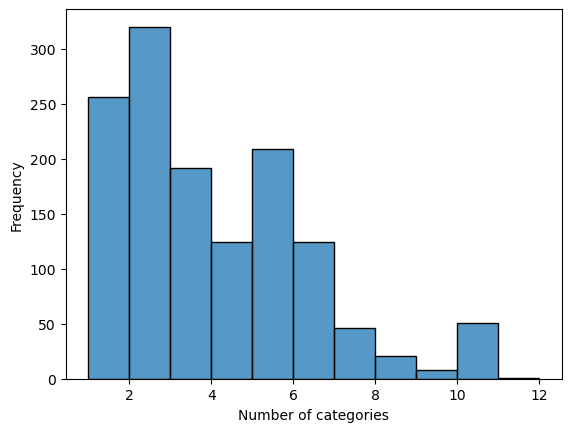

In [19]:
temp = yolosac.loc[categories_bool['Restaurant'], 'category'].map(lambda x : len(x))
sns.histplot(temp, binwidth=1)
plt.xlabel('Number of categories')
plt.ylabel('Frequency')

"Restaurants" can have between 0 and 10 additional categories. Most have 1 additional category.

### Recategorize businesses

In [20]:
def simplify(lst, cats):
  for cat in cats:
    if cat in lst:
        return cats[0]
  return lst

In [23]:
yolosac2 = yolosac
'''
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, education)) # School & College
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, rec)) # Park
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, beauty)) # Beauty salon
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, health)) # Doctor & Hospital
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, car)) # Auto repair shop
'''
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, retail)) # Clothing store
'''
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, restaurant)) # Restaurant
yolosac2['category'] = yolosac2['category'].map( lambda x : simplify(x, grocery)) # Grocery store
'''
print(yolosac2[yolosac2['category'] == 'Clothing store'].info())
print(yolosac2.info())
print()


<class 'pandas.core.frame.DataFrame'>
Index: 2402 entries, 6 to 17937
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            2402 non-null   object 
 1   gmap_id         2402 non-null   object 
 2   category        2402 non-null   object 
 3   avg_rating      2402 non-null   float64
 4   num_of_reviews  2402 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 112.6+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17938 entries, 0 to 17937
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            17938 non-null  object 
 1   gmap_id         17938 non-null  object 
 2   category        17938 non-null  object 
 3   avg_rating      17938 non-null  float64
 4   num_of_reviews  17938 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 700.8+ KB
None


## Playing with Gensim Key Vectors

Download the KeyVector for an existing model: https://nlp.stanford.edu/projects/glove/

In [47]:
import gensim.downloader as api
key_vec = api.load('glove-wiki-gigaword-100')
key_vec.most_similar('restaurant')

[==================================================] 100.0% 128.1/128.1MB downloaded


[('cafe', 0.8286571502685547),
 ('restaurants', 0.8099790215492249),
 ('hotel', 0.7762866020202637),
 ('dining', 0.7583158016204834),
 ('shop', 0.7480155825614929),
 ('eatery', 0.7348136305809021),
 ('diner', 0.7175965905189514),
 ('bakery', 0.714818000793457),
 ('chef', 0.699083685874939),
 ('pub', 0.6867989301681519)]

Generate a list of words that are similar to 'restaurant' but not the 'hotel' or 'retail' categories.

In [82]:
sim_to_restaurant_df = pd.DataFrame(columns=['word', 'similarity to restaurant'], data=key_vec.most_similar(positive=['restaurant'], topn=30))

# Manually remove terms that overlap with retail and hotel categories.
sim_to_restaurant = sim_to_restaurant_df.drop(index=[2,4,11,12,13,16,17,18,23,22,26,28,19])['word'].to_list()
print(sim_to_restaurant)

['cafe', 'restaurants', 'dining', 'eatery', 'diner', 'bakery', 'chef', 'pub', 'bistro', 'pizza', 'bar', 'gourmet', 'tavern', 'diners', 'dinner', 'breakfast', 'cafeteria']


Helper function to classify if a phrase belongs in a category

In [84]:
# Classify if a phrase is similar to the words in a list
# comp is a list of words related to a category, e.g. restaurant-related
def is_it_similar(phrase, comp ,threshold):
  words = phrase.split(' ')
  for w in words:
    for c in comp:
      try:
        sim_score = key_vec.similarity(w, c)
      except KeyError:
        sim_score = 0
      if sim_score > threshold:
        return True
  return False

Select the raw categories that are highly similar to restaurant-related words.

In [88]:
uniq_cat_series = pd.Series(data=unique_cats.index.str.lower())
restaurant = uniq_cat_series[uniq_cat_series.apply(lambda x : is_it_similar(x, sim_to_restaurant, 0.75))]
print(restaurant)

0                           restaurant
1                 fast food restaurant
4                   mexican restaurant
6                   takeout restaurant
9                 breakfast restaurant
                     ...              
2232                    wedding buffet
2246           small plates restaurant
2267    bar restaurant furniture store
2301                          poke bar
2308               raw food restaurant
Name: category, Length: 177, dtype: object


**TO DO: Repeat process for the remaining categories**
* Parks & Rec
* School
* Health
* Beauty
* Auto
* Hotel
* Food retail (i.e. grocery stores, markets)
* Other retail (i.e. clothing, home improvement, etc)
* (Maybe) Entertainment